<a href="https://colab.research.google.com/github/Elma-dev/build_gpt_from_scratch/blob/main/build_llm_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [1]:
# q: quit mode
! pip install tiktoken -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.2 MB/s eta 0:00:00


# Import

In [2]:
# import pytorch module
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset,DataLoader

In [3]:
# import tiktoken
import tiktoken

# Code

In [4]:
# Build data reader
def data_reader(file_path:str):
  with open(file_path, 'r', encoding='utf-8') as f:
    data = f.read()
  return data

In [5]:
# create a data set creator
class DatasetV1(Dataset):
  def __init__(self,text,tokenizer,max_length,stride=1):
    self.tokenizer=tokenizer
    self.input_ids=[]
    self.target_ids=[]
    ids=tokenizer.encode(text)

    for i in range(0,len(ids)-max_length,stride):
      inp=ids[i:i+max_length]
      out=ids[i+1:i+max_length+1]
      self.input_ids.append(torch.tensor(inp))
      self.target_ids.append(torch.tensor(out))
  def __len__(self):
    return len(self.input_ids)
  def __getitem__(self,idx):
    return self.input_ids[idx],self.target_ids[idx]

In [6]:
# test:
# create tokenizer
tokenizer=tiktoken.get_encoding("gpt2")
# read data
text=data_reader("the-verdict.txt")
# create A dataset creator
dataset=DatasetV1(text,tokenizer,8,1)

In [7]:
# get some items
dataset[0]

(tensor([  40,  367, 2885, 1464, 1807, 3619,  402,  271]),
 tensor([  367,  2885,  1464,  1807,  3619,   402,   271, 10899]))

In [8]:
# create DataLoader " torch dataloader gives us the ability to create data batches and other features"
def data_loader(text,max_length=256,stride=128,batch_size=4,shuffle=True,drop_last=True):
  # create tokenizer
  tokenizer=tiktoken.get_encoding("gpt2")
  #create dataset
  dataset=DatasetV1(text,tokenizer,max_length,stride)
  #create data loader
  data_loader_=DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last)
  return data_loader_

In [9]:
data_loader_=data_loader(text,max_length=8,stride=1,shuffle=False,drop_last=False)

In [10]:
#iterate batches: test with the first one
data_loader_iter=iter(data_loader_)
next(data_loader_iter)

[tensor([[   40,   367,  2885,  1464,  1807,  3619,   402,   271],
         [  367,  2885,  1464,  1807,  3619,   402,   271, 10899],
         [ 2885,  1464,  1807,  3619,   402,   271, 10899,  2138],
         [ 1464,  1807,  3619,   402,   271, 10899,  2138,   257]]),
 tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899],
         [ 2885,  1464,  1807,  3619,   402,   271, 10899,  2138],
         [ 1464,  1807,  3619,   402,   271, 10899,  2138,   257],
         [ 1807,  3619,   402,   271, 10899,  2138,   257,  7026]])]

## Creating Token embedding
* token -> ids -> embed_vectors

In [11]:
# create embedder
vocab_size=6
out_size= 3 # means each vocab has a vector of 3 as an embedd
embed_mat=nn.Embedding(vocab_size,out_size)
print(f"the embedding of the word has 3 as id is {embed_mat(torch.tensor([3]))}")
embed_mat.weight

the embedding of the word has 3 as id is tensor([[0.9437, 0.5872, 0.1834]], grad_fn=<EmbeddingBackward0>)


Parameter containing:
tensor([[ 1.3671,  0.5156,  1.1939],
        [ 1.4478, -0.8389, -0.5702],
        [-0.9592, -0.5337, -0.2990],
        [ 0.9437,  0.5872,  0.1834],
        [ 0.6395,  1.7601,  0.1802],
        [ 0.2888, -1.0506, -0.1582]], requires_grad=True)

## Creating Positional Embeddings
 * in this part we will use absolute positional embedding
 * The positional embedding matrix will have this params:

  P(max_size,embed_size)


In [12]:
# example of positional Embedding
max_size=8
embed_size=4
positional_embedding=nn.Embedding(8,4)
positional_embedding.weight

Parameter containing:
tensor([[ 0.9366, -1.7274,  0.0918,  1.1716],
        [ 0.4536, -0.4695, -1.9722, -0.7268],
        [-0.1976, -1.9474, -1.0623, -0.4199],
        [ 0.0366,  0.6850,  0.2261, -1.1250],
        [-0.7882, -0.9891,  0.3084,  0.4879],
        [ 0.6747, -0.0632, -0.5813,  0.8007],
        [-0.9984,  1.1297, -0.7152,  0.2041],
        [-0.1227, -0.3012, -0.5544, -0.6781]], requires_grad=True)

## Part1: Positional Embedding + Word Embedding

In [13]:
class ModelParams:
  def __init__(self):
    self.max_size=4
    self.embedding_size=256
    self.batch_size=8
    self.vocab_size=50257
model_params=ModelParams()

In [14]:
# create data loader
data_loder_=data_loader(text,
            max_length=model_params.max_size,
            stride=model_params.max_size,
            batch_size=model_params.batch_size,
            shuffle=False,
            drop_last=False
            )
# create word Embedding layer
word_embedding=nn.Embedding(
    model_params.vocab_size,
    model_params.embedding_size)
# create positional Embedding layer
position_embedding=nn.Embedding(
    model_params.max_size,
    model_params.embedding_size
)

In [15]:
data_loader_iter=iter(data_loder_)
input_1=next(data_loader_iter)
input_1[0]

tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

In [16]:
word_embedding(input_1[0][0])[0].shape

torch.Size([256])

In [17]:
position_embedding(torch.arange(model_params.max_size)).shape

torch.Size([4, 256])

# Self Attention

##Self Attention without params:

In [18]:
prompt="your journey start with one step"
ids=tokenizer.encode(prompt)
embed_matx=nn.Embedding(len(ids),3)

In [19]:
# embedding of prompt
embed_matx.weight

Parameter containing:
tensor([[-0.3930, -0.8485, -0.3078],
        [-1.8366, -0.8561,  1.8003],
        [ 1.0002,  0.8931, -0.4288],
        [-2.8588, -1.6453, -0.5014],
        [-0.9702,  0.0821, -1.1922],
        [ 0.2308,  0.4843, -2.9306]], requires_grad=True)

In [20]:
#attention of each token with others example: x1,xi
# Attrntion Score
attentions=embed_matx.weight @ embed_matx.weight.T
attentions

tensor([[ 0.9692,  0.8942, -1.0190,  2.6739,  0.6786,  0.4003],
        [ 0.8942,  7.3470, -3.3736,  5.7563, -0.4349, -6.1143],
        [-1.0190, -3.3736,  1.9820, -4.1138, -0.3857,  1.9201],
        [ 2.6739,  5.7563, -4.1138, 11.1312,  3.2362,  0.0128],
        [ 0.6786, -0.4349, -0.3857,  3.2362,  2.3694,  3.3098],
        [ 0.4003, -6.1143,  1.9201,  0.0128,  3.3098,  8.8760]],
       grad_fn=<MmBackward0>)

In [21]:
# normalization of attention matrix
#attention weight
norm_att=torch.softmax(attentions,dim=0)
norm_att

tensor([[1.1263e-01, 1.3070e-03, 2.3795e-02, 2.1125e-04, 2.9504e-02, 2.0741e-04],
        [1.0449e-01, 8.2933e-01, 2.2589e-03, 4.6074e-03, 9.6895e-03, 3.0731e-07],
        [1.5425e-02, 1.8316e-05, 4.7838e-01, 2.3819e-07, 1.0178e-02, 9.4815e-04],
        [6.1947e-01, 1.6900e-01, 1.0775e-03, 9.9480e-01, 3.8076e-01, 1.4079e-04],
        [8.4224e-02, 3.4600e-04, 4.4821e-02, 3.7068e-04, 1.6003e-01, 3.8056e-03],
        [6.3765e-02, 1.1818e-06, 4.4967e-01, 1.4760e-05, 4.0984e-01, 9.9490e-01]],
       grad_fn=<SoftmaxBackward0>)

In [22]:
norm_att@embed_matx.weight

tensor([[-0.0520, -0.0733, -0.0784],
        [-1.5845, -0.8034,  1.4460],
        [ 0.4627,  0.4155, -0.2248],
        [-3.7661, -2.2747, -0.8400],
        [-0.1443, -0.0174, -0.2467],
        [ 0.2566,  0.8630, -3.6167]], grad_fn=<MmBackward0>)

In [23]:
embed_matx.weight

Parameter containing:
tensor([[-0.3930, -0.8485, -0.3078],
        [-1.8366, -0.8561,  1.8003],
        [ 1.0002,  0.8931, -0.4288],
        [-2.8588, -1.6453, -0.5014],
        [-0.9702,  0.0821, -1.1922],
        [ 0.2308,  0.4843, -2.9306]], requires_grad=True)

## Self Attention with Weights
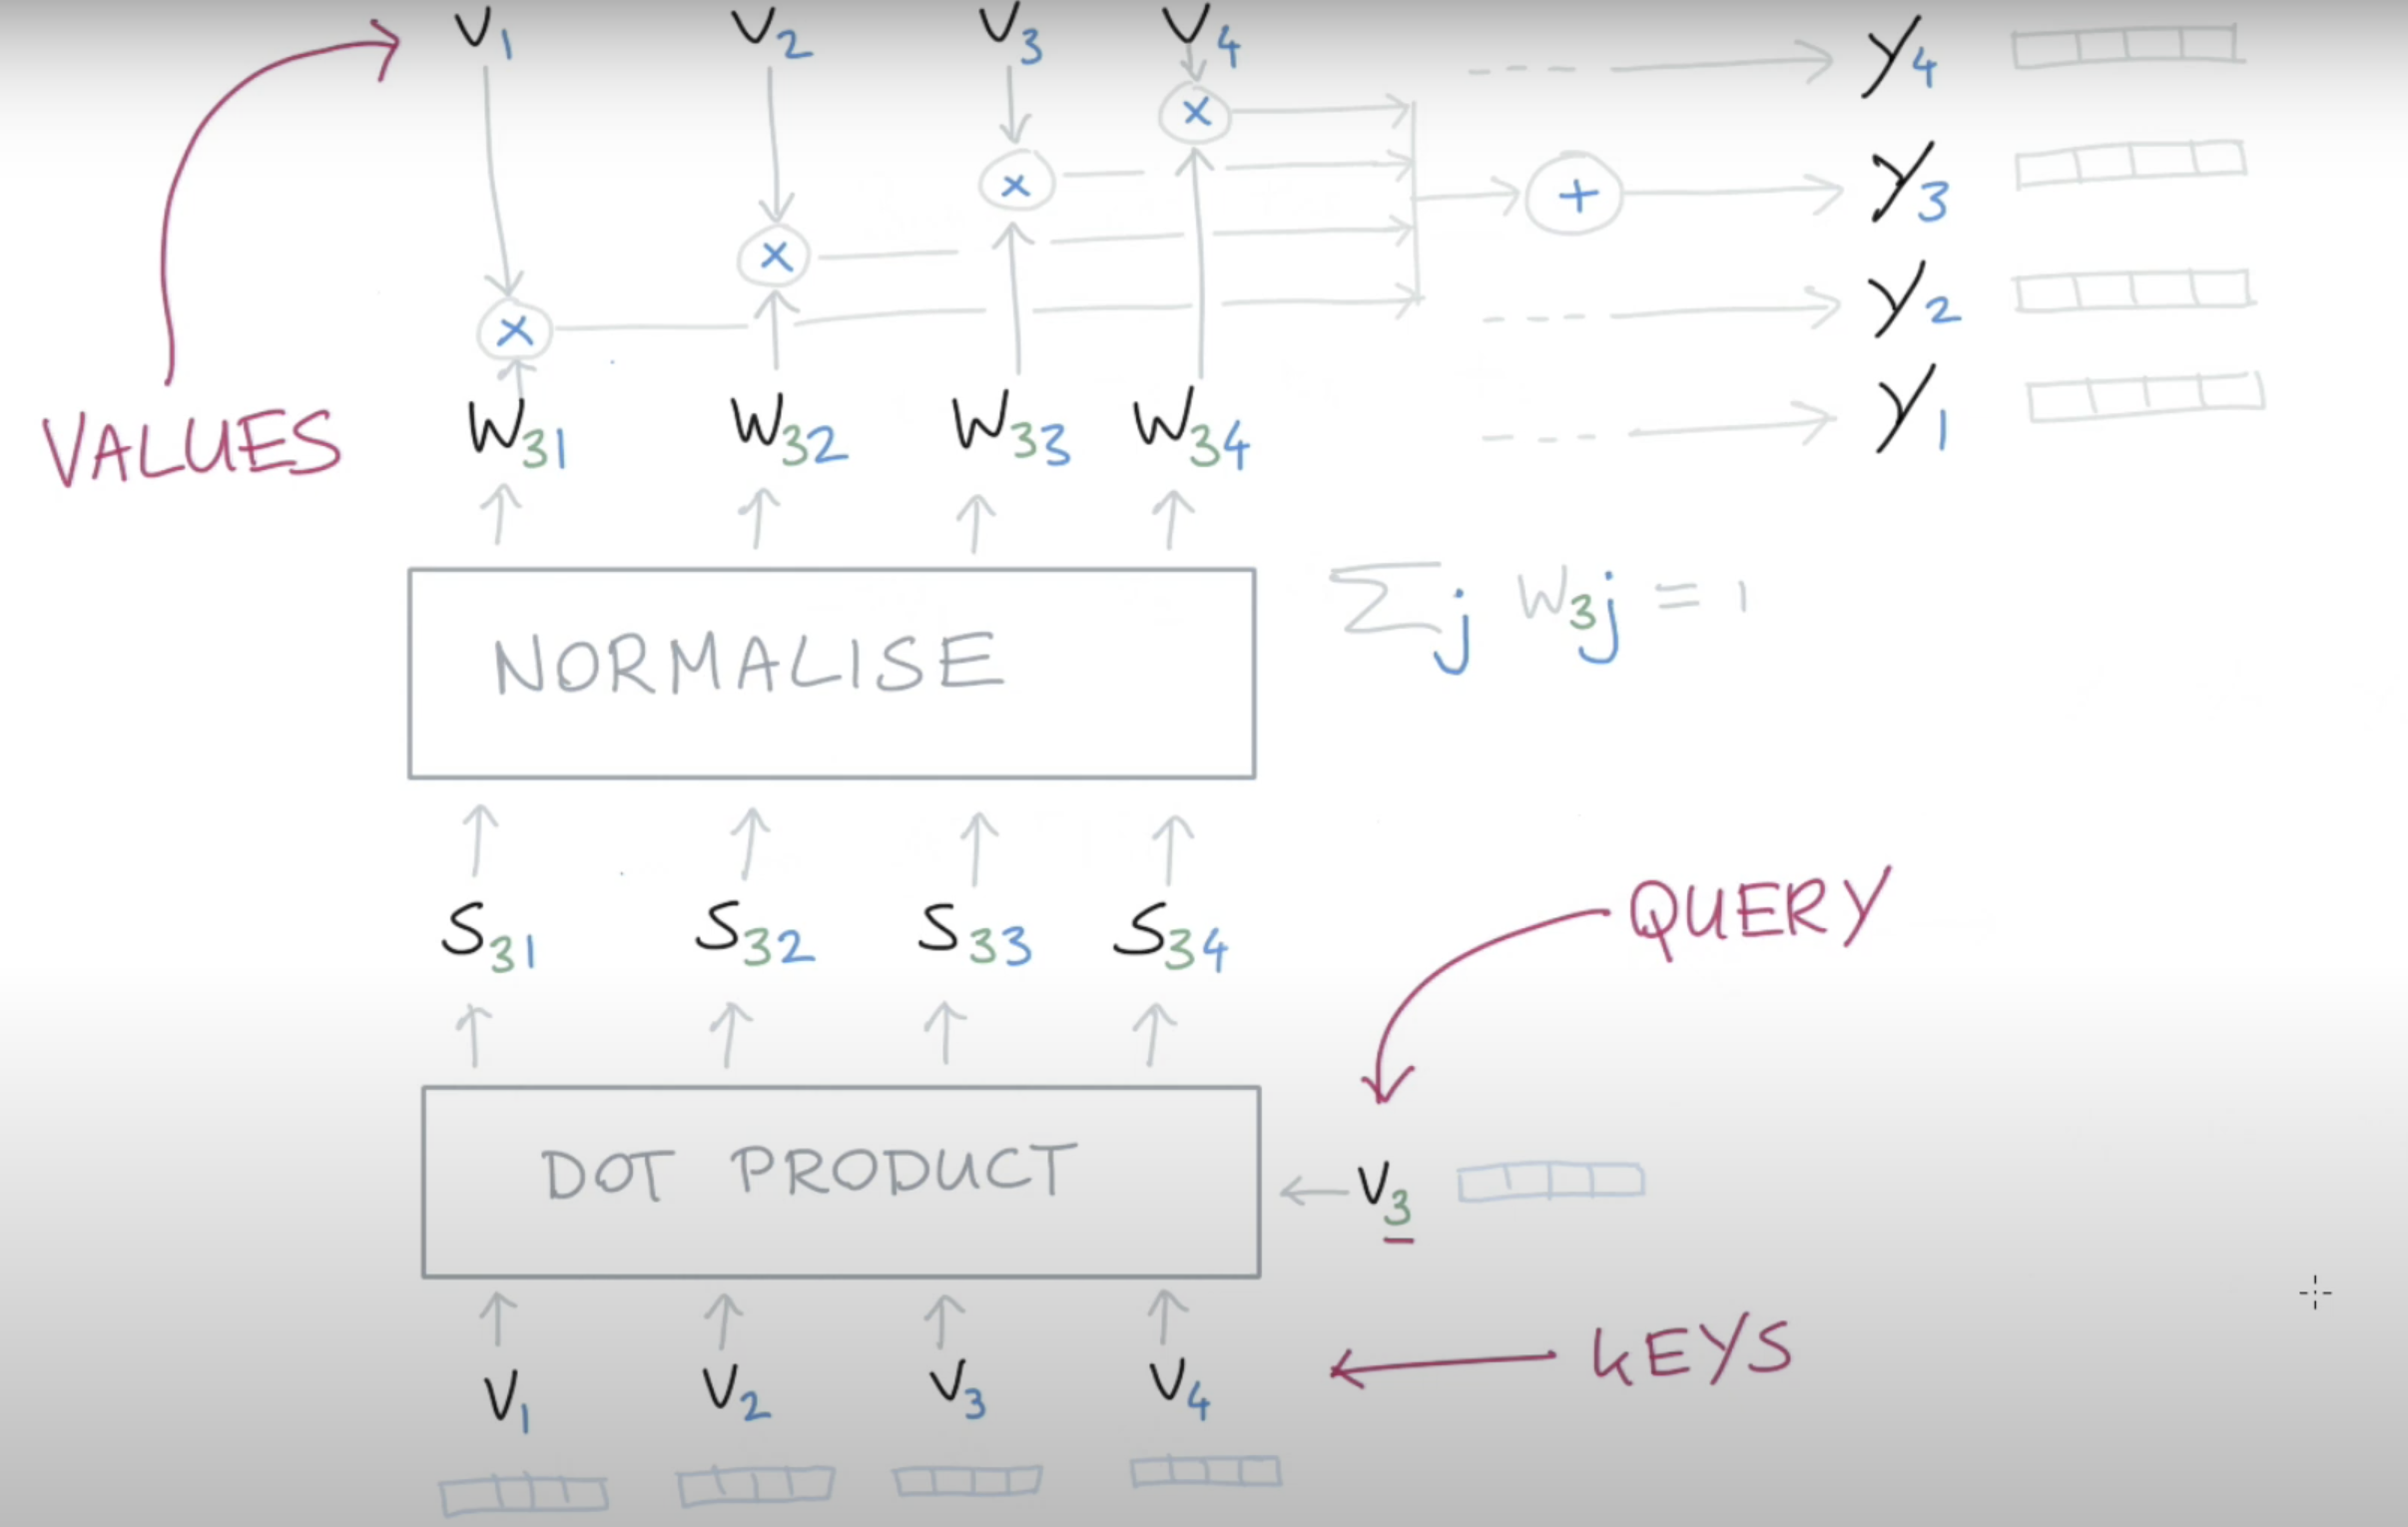

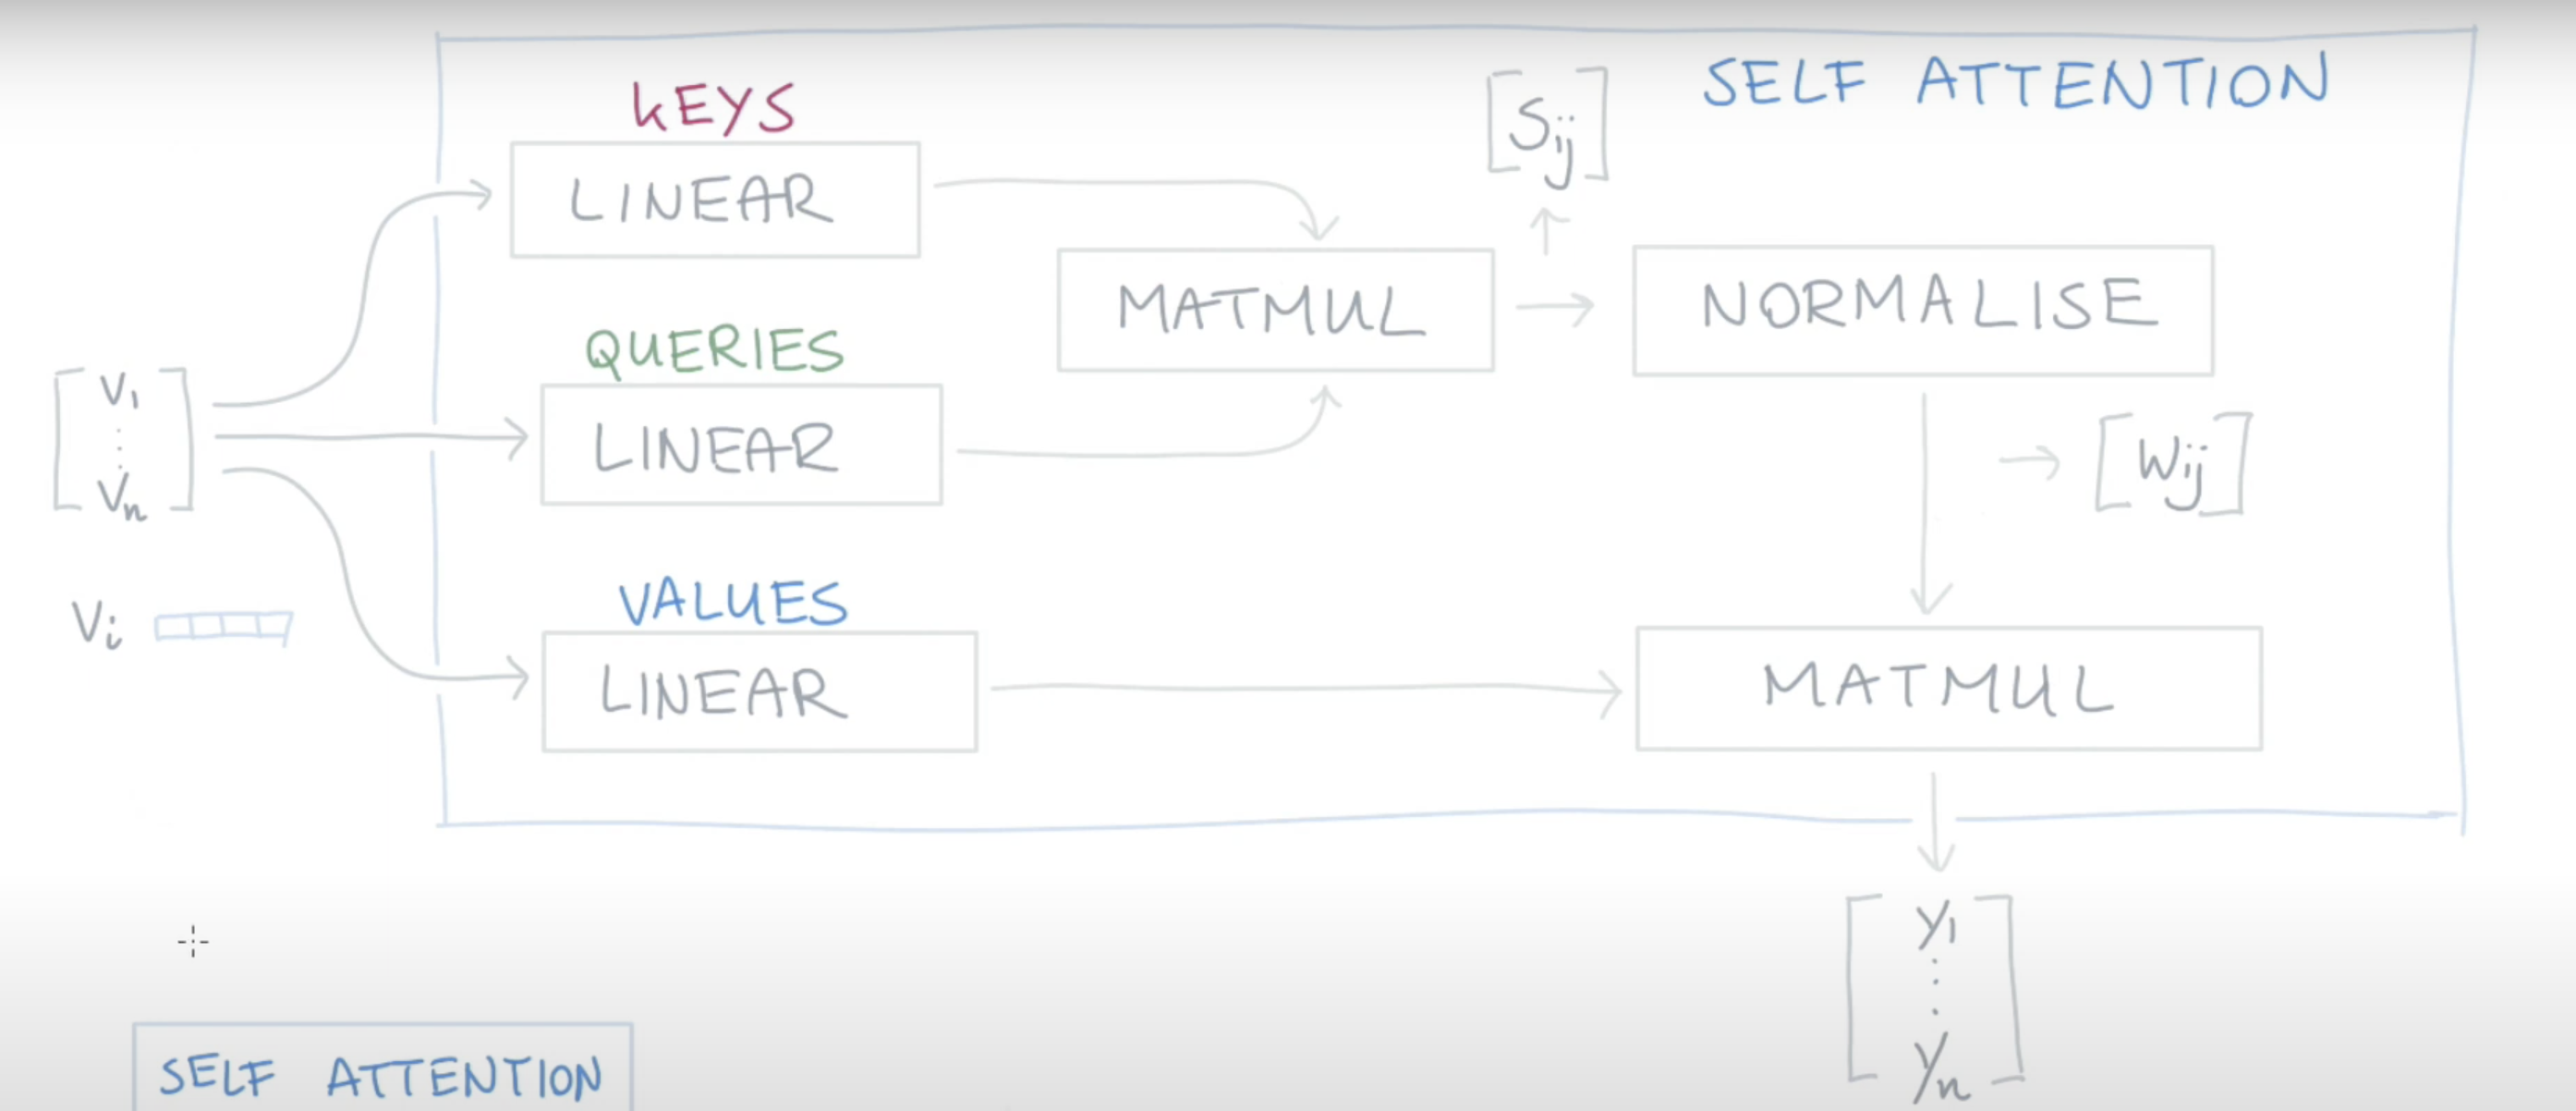

In [24]:
embed_mat.weight

Parameter containing:
tensor([[ 1.3671,  0.5156,  1.1939],
        [ 1.4478, -0.8389, -0.5702],
        [-0.9592, -0.5337, -0.2990],
        [ 0.9437,  0.5872,  0.1834],
        [ 0.6395,  1.7601,  0.1802],
        [ 0.2888, -1.0506, -0.1582]], requires_grad=True)

In [25]:
# let's take e3 as query
x_3=embed_mat.weight[2]

In [26]:
# create the query, key and val params ==> .shape[0] == x_3.shape[0]
in_dim=x_3.shape[0]
out_dim=2

In [27]:
w_key=torch.nn.Parameter(torch.randn(in_dim,out_dim),requires_grad=False)
w_query=torch.nn.Parameter(torch.randn(in_dim,out_dim),requires_grad=False)
w_val=torch.nn.Parameter(torch.randn(in_dim,out_dim),requires_grad=False)

In [28]:
print(w_key)
print(w_query)
print(w_val)

Parameter containing:
tensor([[ 1.0997, -1.1618],
        [-0.9024,  0.0725],
        [ 1.4129, -1.4521]])
Parameter containing:
tensor([[-0.0980,  1.0936],
        [-0.9946, -0.2391],
        [ 1.4736, -0.9510]])
Parameter containing:
tensor([[-0.8580,  0.9699],
        [ 0.6039,  1.4238],
        [-2.4667,  0.0237]])


In [29]:
# in_embed --> key_linear
in_key=embed_mat.weight @ w_key
# input_3: query --> query_linear
in3_query=x_3 @ w_query

print(f"inputs --> key_linear: {in_key}")
print(f"input3:query --> query_linear: {in3_query}")


inputs --> key_linear: tensor([[ 2.7250, -3.2847],
        [ 1.5436, -0.9149],
        [-0.9957,  1.5099],
        [ 0.7670, -1.3201],
        [-0.6306, -0.8770],
        [ 1.0421, -0.1819]], grad_fn=<MmBackward0>)
input3:query --> query_linear: tensor([ 0.1842, -0.6370], grad_fn=<SqueezeBackward4>)


In [30]:
# dot product
in_kq=in3_query @ in_key.T
print(f"the attention scores between x3 and other key {in_kq}")

the attention scores between x3 and other key tensor([ 2.5943,  0.8671, -1.1452,  0.9822,  0.4425,  0.3079],
       grad_fn=<SqueezeBackward4>)


In [31]:
# Normalization
norm_in_kq=F.softmax(in_kq,dim=-1)
norm_in_kq

tensor([0.6177, 0.1098, 0.0147, 0.1232, 0.0718, 0.0628],
       grad_fn=<SoftmaxBackward0>)

In [32]:
# inputs as a values
in_val=embed_mat.weight @ w_val
in_val

tensor([[-3.8066,  2.0885],
        [-0.3424,  0.1963],
        [ 1.2382, -1.6974],
        [-0.9075,  1.7557],
        [ 0.0699,  3.1306],
        [-0.4920, -1.2195]], grad_fn=<MmBackward0>)

In [33]:
norm_in_kq @ in_val

tensor([-2.5084,  1.6513], grad_fn=<SqueezeBackward4>)

In [34]:
sum=0
for k,v in enumerate(norm_in_kq):
    sum+=v*in_val[k]
sum

tensor([-2.5084,  1.6513], grad_fn=<AddBackward0>)

## Build COmpact Self Attention class

In [47]:
class SelfAttention_v1(nn.Module):
  def __init__(self,in_d,out_d):
    super().__init__()
    self.in_dim=in_d
    self.out_dim=out_dim
    self.W_key=nn.Parameter(torch.randn(self.in_dim,self.out_dim))
    self.W_query=nn.Parameter(torch.randn(self.in_dim,self.out_dim))
    self.W_value=nn.Parameter(torch.randn(self.in_dim,self.out_dim))

  def forward(self,X):
    att_weights=self.__attentions_scores(X)
    return self.__vect_context(att_weights)

  def __attentions_scores(self,X):
    queries = X @ self.W_query
    keys = X @ self.W_key
    scores=queries @ keys.T
    norm_scores=torch.softmax(X/keys.shape[-1]**0.5,dim=-1)
    return norm_scores

  def __vect_context(self,att_weights):
    return att_weights @ self.W_value

In [48]:
self_att=SelfAttention_v1(3,2)
self_att.forward(embed_mat.weight)

tensor([[-0.4005, -0.3763],
        [-0.4172,  0.1215],
        [-0.4285, -0.6268],
        [-0.4596, -0.3140],
        [-0.5477, -0.5424],
        [-0.3915, -0.2776]], grad_fn=<MmBackward0>)